# Chapter 10
In this chapter we look at:

* Grid/Exhaustive search
* Previous Chapters

In [chapter 1](chapter1.ipynb) (a closely related notebook see hyperlink) We look at optimization outputs that came from an optimization using spike waveform shape. 

In [chapter 2](chapter2.ipynb) (a closely related notebook see hyperlink) I demonstrate optimization using spike time statistics via the allen SDK Chapter 2

In [chapter 3](chapter3.ipynb) (a closely related notebook see hyperlink) We will take a closer at the neuroelectro data used to perform the fits in notebook1/Chapter 1. Specifically we will look at where optimized model behavior fits back onto the distribution of neuroelectro data.

In [chapter 5](chapter5.ipynb) (a closely related notebook see hyperlink) We will look at projections of Optimized cells onto a Druckman feature space, we will also look at extracting Allen SDK features from the optimized cells. Chapter 3


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.plot([0],[1])
plt.show()

<Figure size 640x480 with 1 Axes>

In a very simple example below. The OptMan class is instanced and used to perform simple optimization jobs including:
Exhaustive Search, running a genetic algorithm (nsga3), or round trip testing with simulated data


In [2]:
%%capture
from allensdk.ephys.extract_cell_features import extract_cell_features
import pickle
from neuronunit.optimisation.optimization_management import OptMan, TSD
from neuronunit.optimisation import model_parameters
from neuronunit.optimisation.model_parameters import MODEL_PARAMS
import pandas as pd
import os

In [ ]:
import os
electro_path = str(os.getcwd())+'/../tests/russell_tests.p'

assert os.path.isfile(electro_path) == True
with open(electro_path,'rb') as f:
    (test_frame,obs_frame) = pickle.load(f)
local_tests = test_frame['Hippocampus CA1 pyramidal cell']
local_tests = TSD(local_tests)
local_tests.use_rheobase_score = True    
local_tests.optimize(free_params=free_params,MU=10,NGEN=10)

In [4]:
%%capture
free_params=['gK','gNa','ENa','C']
import copy
for f in free_params:
    hold_constant = copy.copy(MODEL_PARAMS['BHH'])
    hold_constant.pop(f,'None')
    OM = OptMan(local_tests,backend=str('BHH'),\
        boundary_dict=MODEL_PARAMS['BHH'],\
        protocol={'elephant':True,'allen':False,'dm':False},hc=hold_constant)#'tsr':spk_range})
ga_results = OM.optimize(free_params=free_params,MU=8,NGEN=8)#,hold_constant=hold_constant)

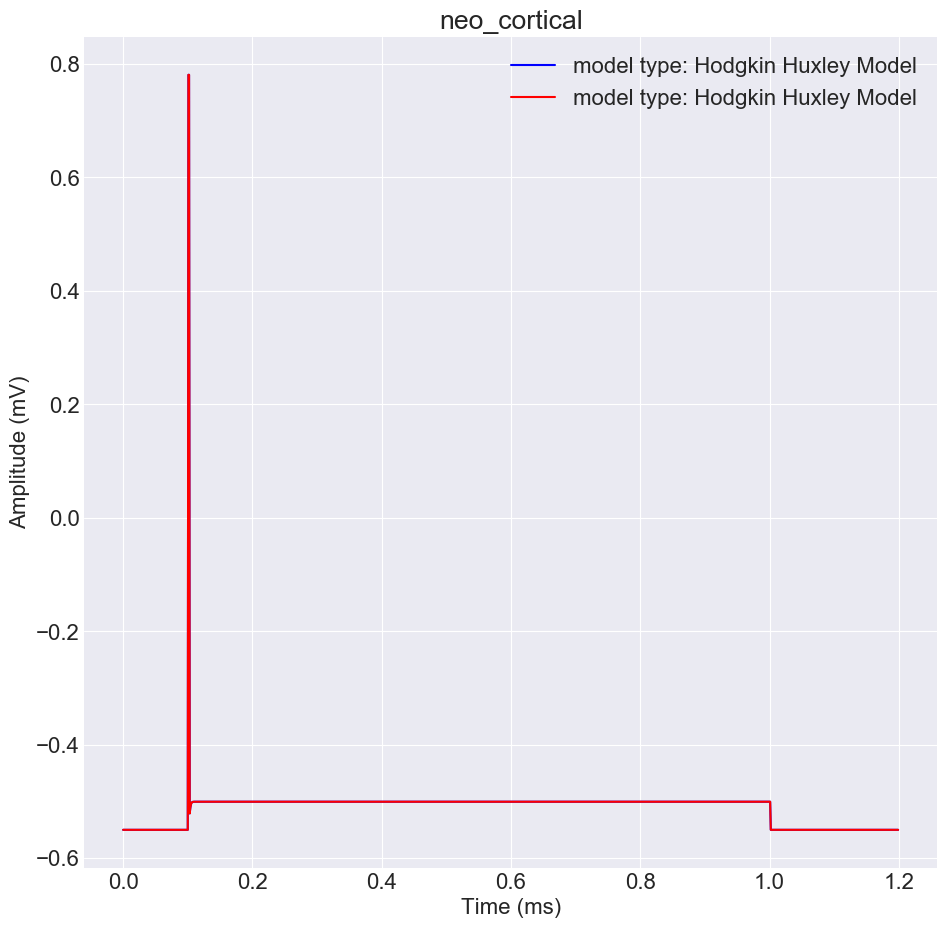

In [5]:
from neuronunit.plottools import inject_and_plot

dtcpop = [d.dtc for d in ga_results['pf']]
dtcpop = inject_and_plot(dtcpop,second_pop=dtcpop)

#vm_pop = [d.vm for d in dtcpop]

In [ ]:
ga_results['pf'][0].dtc.attrs
ga_results['pf'][0].dtc.scores
ga_results['pf'][0].dtc.tests
dtcpop = [ga_results['pf'][0].dtc for i in range(0,10) ]
dtcpop = list(map(OM.elephant_evaluation,dtcpop))
#ga_results['pop'][0].dtc.tests


Ratio = 6.96
{'mean': array(-79.) * mV, 'std': array(-1185.) * mV, 'n': 2578, 'value': array(-79.) * mV} {'std': array(-1.68512975e-10) * V, 'mean': array(-0.55) * V}
failed at:  True InputResistanceTest <class 'sciunit.scores.complete.ZScore'> None 384.45 megaohm
1
0
1
1
gets here
gets here
0
gets here
0
1
gets here
[(array(275.5) * pA, <neuronunit.optimisation.data_transport_container.DataTC object at 0x7ff2b16e9588>), (array(367.) * pA, <neuronunit.optimisation.data_transport_container.DataTC object at 0x7ff2b8a81320>), (array(458.5) * pA, <neuronunit.optimisation.data_transport_container.DataTC object at 0x7ff2b15402e8>), (array(550.) * pA, <neuronunit.optimisation.data_transport_container.DataTC object at 0x7ff2b8a906a0>)]
0
0
0
1
gets here
1
gets here
1
gets here
1
gets here
[(array(275.5) * pA, <neuronunit.optimisation.data_transport_container.DataTC object at 0x7ff2b16e9ac8>), (array(367.) * pA, <neuronunit.optimisation.data_transport_container.DataTC object at 0x7ff2b8a7ac88>)

In [ ]:
[dtc.scores for dtc in dtcpop]

In [ ]:
#%%capture#
free_params=['b','C','peak_v']
import copy
for f in free_params:
    hold_constant = copy.copy(MODEL_PARAMS['ADEXP'])
    hold_constant.pop(f,'None')

OM = OptMan(local_tests,backend=str('ADEXP'),\
            boundary_dict=MODEL_PARAMS['ADEXP'],\
            protocol={'elephant':True,'allen':False,'dm':False},hc=hold_constant)
ga_results = OM.optimize(free_params=['b','C','peak_v'],MU=5,NGEN=5)


In [ ]:
# res = OM.round_trip_test(local_tests,str('RAW'),MU=1,NGEN=1)#,stds = easy_standards)
ga_results['pf'][0].dtc.scores
ga_results['pf'][0].dtc.scores_ratio
print(ga_results['dtc_pop'][0].scores)
local_tests

In [ ]:
%%capture
# restrict the number of free parameters to 3, to make the grid search computationally tractable.
#MODEL_PARAMS['ADEXP']
%%timeit grid_results,sorted_pop = OM.run_simple_grid(2,free_params=['b','C','peak_v'])

In [ ]:
opt=ga_results['pf'][0].dtc.scores_ratio
opt

In [ ]:
if type(opt) is not type(None):
    print('its {0}, that ga beat grid'.format(opt<grid_results[0].dtc.scores))
    grid_results[-1].dtc.scores
    len(grid_results)
    print(grid_results[-1].dtc.scores_ratio)
    print(grid_results[0].dtc.scores_ratio)


In [ ]:

%%capture
%%timeit OM = OptMan(local_tests,backend=str('RAW'),boundary_dict=MODEL_PARAMS['RAW'],protocol={'elephant':True,'allen':False,'dm':False})#'tsr':spk_range})
# restrict the number of free parameters to 3, to make the grid search computationally tractable.
grid_results,sp = OM.run_simple_grid(5,free_params=['a','b','C'])


In [ ]:
%%capture

%%timeit ga_results_izh = OM.optimize(free_params=['a','b','C'],MU=3,NGEN=3)

len([ (gr.dtc.scores,gr.dtc.attrs) for gr in grid_results ])

In [ ]:
#[ (gr.dtc.scores,gr.dtc.attrs,gr) for gr in grid_results ] 

# Sort this list to find optimal solution from grid search.
* Use optimal solution to seed a genetic algorithm.

This will be a fast way of showing that the genetic algorithm can find a better solution. Alternatively we could start the GA from scratch, but if the genetic algorithm was not working at all, this would be a faster way to demonstrate it. Since time is short, let us do it the fast way first.



In [ ]:
dtc_pop = sorted([ (gr.dtc.scores_ratio,gr.dtc.attrs,gr) for gr in grid_results ], key=lambda tup: tup[0])

# Ground truth via exhaustive search is:


In [ ]:
print('The model implied by parameters: {0}'.format(dtc_pop[0][1]))
print('Yields the scores: {0}'.format(dtc_pop[0][2].dtc.scores))
print('Yields the ratio scores: {0}'.format(dtc_pop[0][2].dtc.scores_ratio))

* Now lets create a seed population from the top 10 exhaustive search results.


In [ ]:
gene_pop = [d[2] for d in dtc_pop[0:10]]
len(dtc_pop)

In [ ]:
%%capture 
%%timeit results = local_tests.optimize(MODEL_PARAMS['RAW'],backend='RAW',protocol={'allen': False, 'elephant': True},\
                               NGEN=len(gene_pop)+len(gene_pop),MU=len(gene_pop)+len(gene_pop), free_params=dtc_pop[0][1].keys(), \
                               seed_pop=gene_pop)
#(NGEN = 10, MU=len(gene_pop), seed_pop = gene_pop,backend='RAW',)
#[ (gr.dtc.scores,gr.dtc.attrs) for gr in grid_results ] 

# Optimization management classes: 
* can also do things like round-trip testing (test the simulators internal performance, as if to bench mark itself with simulated neural data).

In [ ]:
results[0]['dtc_pop'][0].scores
opt_out = results[0]['dtc_pop'][0].scores_ratio
opt_out

In [ ]:
grid_out = dtc_pop[0][2].dtc.scores_ratio

print('its true that ga beat exhaustive search {0}'.format(opt_out<grid_out))
print('its true that ga was no worse than exhaustive search {0}'.format(opt_out==grid_out))

print(results[0]['dtc_pop'][0].attrs,'grid best parameters')
print(dtc_pop[0][2].dtc.attrs,'grid best parameters')
grid_out

In [ ]:
grid_out = dtc_pop[0][2].dtc.scores_ratio
opt_out

In [ ]:
results_no_seed = local_tests.optimize(MODEL_PARAMS['RAW'],backend='RAW',protocol={'allen': False, 'elephant': True},\
                               NGEN=len(gene_pop)+len(gene_pop),MU=len(gene_pop)+len(gene_pop),\
                               free_params=dtc_pop[0][1].keys())


In [ ]:
grid_results_4 = OM.run_simple_grid(4,free_params=['a','b','c','C'])
results_no_seed_4 = local_tests.optimize(MODEL_PARAMS['RAW'],backend='RAW',protocol={'allen': False, 'elephant': True},\
                               NGEN=len(gene_pop)+len(gene_pop),MU=len(gene_pop)+len(gene_pop),\
                               free_params=dtc_pop[0][1].keys())



In [ ]:
%%capture


In [ ]:
results_no_seed_4

In [ ]:
print('Yields the scores: {0}'.format(results_no_seed_4[0]['pf'][0].dtc.scores))
print('Yields the ratio scores: {0}'.format(results_no_seed_4[0]['pf'][0].dtc.scores_ratio))
print('The model implied by parameters: {0}'.format(grid_results_4[0][1].dtc.scores_ratio))
print('it seems like the optimizer can often beat the grid search but it really depends')